## CogVideoX Image-to-Video

This notebook demonstrates how to run [CogVideoX-5b-I2V](https://huggingface.co/THUDM/CogVideoX-5b-I2V) with 🧨 Diffusers on a free-tier Colab GPU.

Additional resources:
- [Docs](https://huggingface.co/docs/diffusers/en/api/pipelines/cogvideox)
- [Quantization with TorchAO](https://github.com/sayakpaul/diffusers-torchao/)
- [Quantization with Quanto](https://gist.github.com/a-r-r-o-w/31be62828b00a9292821b85c1017effa)

Note: If, for whatever reason, you randomly get an OOM error, give it a try on Kaggle T4 instances instead. I've found that Colab free-tier T4 can be unreliable at times. Sometimes, the notebook will run smoothly, but other times it will crash with an error 🤷🏻‍♂️

#### Install the necessary requirements

In [ ]:
!pip install diffusers transformers hf_transfer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 83.2 MB/s eta 0:00:00


In [ ]:
# !pip install git+https://github.com/huggingface/accelerate
!pip install accelerate==0.33.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 23.0 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.1.1
    Uninstalling accelerate-1.1.1:
      Successfully uninstalled accelerate-1.1.1


#### Import required libraries

The following block is optional but if enabled, downloading models from the HF Hub will be much faster

In [ ]:
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

In [ ]:
import torch
from diffusers import AutoencoderKLCogVideoX, CogVideoXImageToVideoPipeline, CogVideoXTransformer3DModel
from diffusers.utils import export_to_video, load_image
from transformers import T5EncoderModel

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

#### Load models and create pipeline

Note: `bfloat16`, which is the recommended dtype for running "CogVideoX-5b-I2V" will cause OOM errors due to lack of efficient support on Turing GPUs.

Therefore, we must use `float16`, which might result in poorer generation quality. The recommended solution is to use Ampere or above GPUs, which also support efficient quantization kernels from [TorchAO](https://github.com/pytorch/ao) :(

In [ ]:
model_id = "THUDM/CogVideoX-5b-I2V"

In [ ]:
!huggingface-cli login --token "replace with your hugging face token here"

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
The token `stable_diffusion` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `stable_diffusion`


In [ ]:
transformer = CogVideoXTransformer3DModel.from_pretrained(model_id, subfolder="transformer", torch_dtype=torch.float16)
text_encoder = T5EncoderModel.from_pretrained(model_id, subfolder="text_encoder", torch_dtype=torch.float16)
vae = AutoencoderKLCogVideoX.from_pretrained(model_id, subfolder="vae", torch_dtype=torch.float16)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


transformer/config.json:   0%|          | 0.00/802 [00:00<?, ?B/s]

(…)ion_pytorch_model.safetensors.index.json:   0%|          | 0.00/103k [00:00<?, ?B/s]

(…)pytorch_model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

(…)pytorch_model-00002-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

(…)pytorch_model-00003-of-00003.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

(…)ext_encoder/model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.53G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

vae/config.json:   0%|          | 0.00/839 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

In [ ]:
# Create pipeline and run inference
pipe = CogVideoXImageToVideoPipeline.from_pretrained(
    model_id,
    text_encoder=text_encoder,
    transformer=transformer,
    vae=vae,
    torch_dtype=torch.float16,
)

model_index.json:   0%|          | 0.00/423 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

tokenizer/added_tokens.json:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

#### Enable memory optimizations

Note that sequential cpu offloading is necessary for being able to run the model on Turing or lower architectures. It aggressively maintains everything on the CPU and only moves the currently executing nn.Module to the GPU. This saves a lot of VRAM but adds a lot of overhead for inference, making generations extremely slow (1 hour+). Unfortunately, this is the only solution for running the model on Colab until efficient kernels are supported.

In [ ]:
pipe.enable_sequential_cpu_offload()
# pipe.vae.enable_tiling()

In [ ]:
#image=load_image("/content/sample_data/images/IMG20241020200449.jpg")


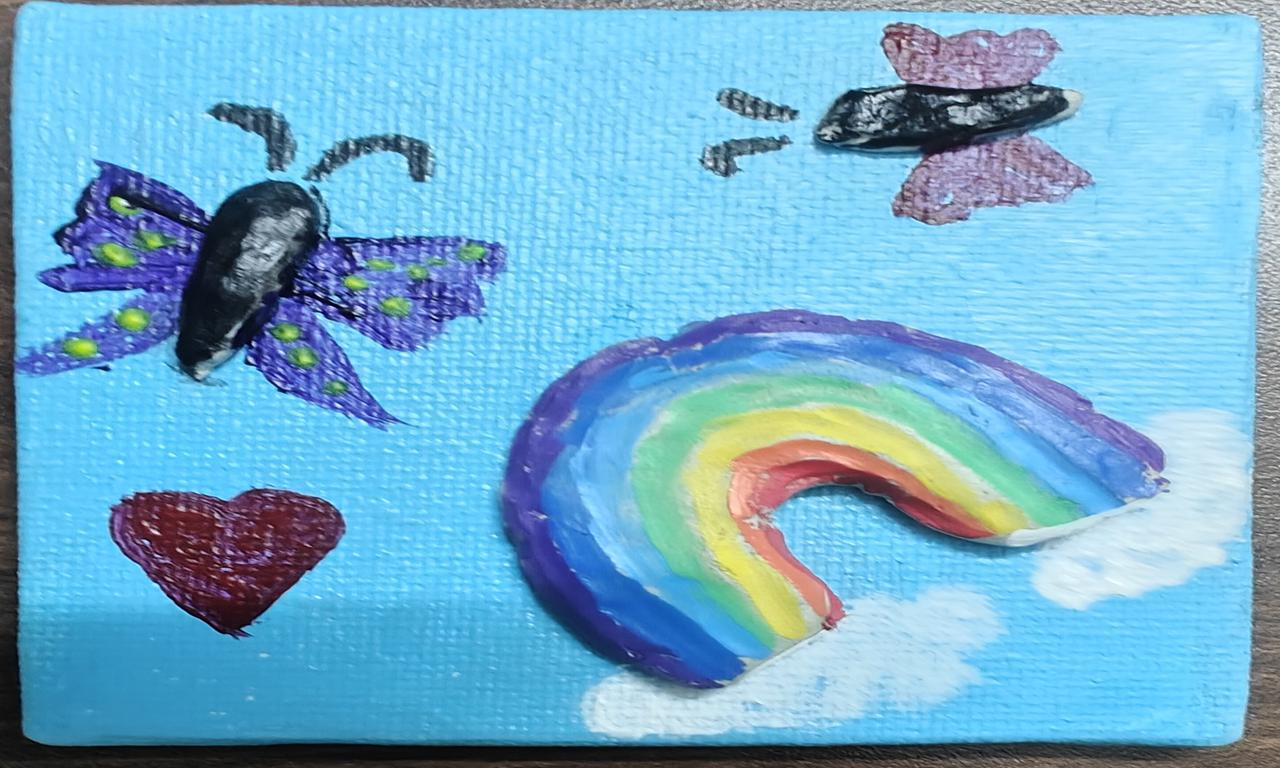

In [ ]:
 #image

#### Generate!

In [ ]:
#prompt = "An astronaut hatching from an egg, on the surface of the moon, the darkness and depth of space realised in the background. High quality, ultrarealistic detail and breath-taking movie-like camera shot."
#image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/astronaut.jpg")

In [ ]:
#prompt = "A  sketch of a woman waking and drone shot paning from behind with cinematic effect"
#prompt = "A painting where Coconuts are from a tree with a moving colors behinds"

In [ ]:
#video = pipe(image=image, prompt=prompt, guidance_scale=6, use_dynamic_cfg=True, num_inference_steps=50).frames[0]

In [ ]:
#input_2=" Animate the tree growing taller, branches swaying, and leaves changing colors from green to purple."

In [ ]:
#video = pipe(image=image, prompt=input_2, guidance_scale=6, use_dynamic_cfg=True, num_inference_steps=50).frames[0]

In [ ]:
#export_to_video(video, "R10.mp4", fps=8)

In [ ]:
## Addding Langgraph Agents

In [ ]:
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.8/120.8 kB 9.3 MB/s eta 0:00:00


In [ ]:
!pip install langchain langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.3/409.3 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.2 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.15
    Uninstalling langchain-core-0.3.15:
      Successfully uninstalled langchain-core-0.3.15


In [ ]:
!pip install python-dotenv

In [ ]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Now you can access your environment variables using os.environ
os.environ['OPENAI_API_KEY'] = "Repalce with your open ai api key here"

In [ ]:
from langchain_openai import ChatOpenAI

# Set the model as ChatOpenAI
model = ChatOpenAI(temperature=0)

#Call the model with a user message
model.invoke('Hey there')

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-c797358d-bb09-4bc3-8670-c0e7acf5ff5f-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [ ]:
model

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7a5caaf31360>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7a5caaeff8e0>, root_client=<openai.OpenAI object at 0x7a5d74430a60>, root_async_client=<openai.AsyncOpenAI object at 0x7a5caaf31330>, temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'))

In [ ]:
# Define the AgentState class to store state variables
from typing import TypedDict

class AgentState(TypedDict):
    image_path: str
    description:str
    desc_for_animation:str
    tilte_for_video:str

In [ ]:
def how_to_animate_desc(state: AgentState):
    try:
        print("In how_to_animate_desc")

        # Retrieve description from the state
        description = state.get("description")
        if not description:
            raise ValueError("Description missing in state")

        # Formulate and invoke the animation description query
        complete_query = ("Your task is to provide instructions for a creative animation in 15 words for an image description. "
                          "If it involves people, add facial expressions. Following is the image description: " + description)

        response = model.invoke(complete_query)

        # Check if response content is available
        if not response or not hasattr(response, 'content'):
            raise ValueError("No response content from model")

        print("Agent Says how_to_animate: " + response.content)

        # Retrieve image path from state
        image_path = state.get('image_path')
        if not image_path:
            raise ValueError("Image path missing in state")

        # Update state with animation description
        state["desc_for_animation"] = response.content
        return {
            "image_path": image_path,
            "desc_for_animation": response.content
        }

    except Exception as e:
        print(f"Error in how_to_animate_desc: {e}")
        return None


def title_for_video(state: AgentState):
    try:
        print("Creating Title for Video")

        # Retrieve description and animation description from the state
        description = state.get("description")
        desc_for_animation = state.get("desc_for_animation")
        if not description or not desc_for_animation:
            raise ValueError("Required information missing in state (description or desc_for_animation)")

        # Formulate and invoke the title generation query
        complete_query = ("Your task is to provide a title for the image description given an example like A_Boat_Sailing. "
                          "Following is the image description: " + description)

        response = model.invoke(complete_query)

        # Check if response content is available
        if not response or not hasattr(response, 'content'):
            raise ValueError("No response content from model")

        print("Agent Says the title is: " + response.content)

        # Retrieve image path from state
        image_path = state.get('image_path')
        if not image_path:
            raise ValueError("Image path missing in state")

        # Update state with the title for the video
        state["tilte_for_video"] = response.content
        return {
            "image_path": image_path,
            "tilte_for_video": response.content,
            "desc_for_animation": desc_for_animation
        }

    except Exception as e:
        print(f"Error in title_for_video: {e}")
        return None


def create_animation(state: AgentState):
    try:
        print("Creating Animation")

        # Retrieve animation description and title from the state
        desc_for_animation = state.get("desc_for_animation")
        title = state.get("tilte_for_video")
        image_path = state.get("image_path")

        if not desc_for_animation or not title or not image_path:
            raise ValueError("Missing required information in state (desc_for_animation, tilte_for_video, or image_path)")

        print(f"Creating Animation - desc_for_animation: {desc_for_animation}")
        print(f"Creating Animation - title_for_video: {title}")
        print(f"Creating Animation - image path: {image_path}")

        # Load the image
        image = load_image(image_path)
        print("Animation started for: " + desc_for_animation)

        # Define the output path for the video
        output_directory = "/content/sample_data/output_videos/"
        os.makedirs(output_directory, exist_ok=True)
        output_path = os.path.join(output_directory, f"{title}.mp4")

        print("Exporting video to:", output_path)

        # Generate the video based on the animation description
        video = pipe(image=image, prompt=desc_for_animation, guidance_scale=6, use_dynamic_cfg=True, num_inference_steps=50).frames[0]

        # Export the video
        export_to_video(video, output_path, fps=8)
        print("Animation created and saved successfully!")

        return f"Agent Says: Animation created for {desc_for_animation}"

    except Exception as e:
        print(f"Error in create_animation: {e}")
        return None


In [ ]:
# Import necessary modules from langgraph
from langgraph.graph import StateGraph, END
from langgraph.graph import Graph  # Optional, if Graph is used elsewhere in your code

# Initialize the workflow graph using AgentState
workflow = StateGraph(AgentState)

# Add nodes to the workflow, representing each step in the process
workflow.add_node("Describe_Animation", how_to_animate_desc)  # Node 1: Generate animation description
workflow.add_node("Create_Title", title_for_video)            # Node 2: Generate title for the video
workflow.add_node("Create_Animation", create_animation)       # Node 3: Create the animation video

# Define the edges between nodes to establish the flow
workflow.add_edge("Describe_Animation", "Create_Title")       # Transition from description to title creation
workflow.add_edge("Create_Title", "Create_Animation")         # Transition from title creation to animation creation

# Set the entry and finish points for the workflow
workflow.set_entry_point("Describe_Animation")                # Starting node
workflow.set_finish_point("Create_Animation")                 # Ending node

# Compile the workflow to create an executable app
app = workflow.compile()

print("Workflow has been successfully compiled and is ready to execute.")


Workflow has been successfully compiled and is ready to execute.


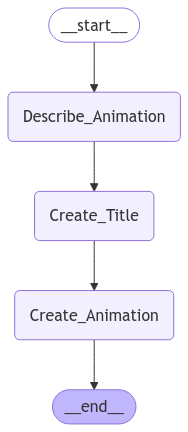

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
# Example usage
#image_path = '/content/sample_data/images/IMG-20241027-WA0057.jpg'  # Replace with your image path
#description = describe_image(image_path)
#print("Image description:", description)
#app.invoke(image_path,description)

In [ ]:
import os
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

# Function to describe an image
def describe_image(image_path):
    """
    Generates a description for a given image using the BLIP model.

    Parameters:
        image_path (str): The path to the image file.

    Returns:
        str: A generated caption describing the image.
    """
    try:
        # Load the model and processor from Hugging Face
        processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

        # Open the image and prepare it for processing
        image = Image.open(image_path).convert('RGB')

        # Process the image and generate caption
        inputs = processor(image, return_tensors="pt")
        output = model.generate(**inputs)
        caption = processor.decode(output[0], skip_special_tokens=True)

        return caption

    except Exception as e:
        print(f"Error generating description for {image_path}: {e}")
        return None

# Directory containing images
image_directory = '/content/sample_data/images'

# Process each image in the directory
for filename in os.listdir(image_directory):
    # Check for valid image file types
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        image_path = os.path.join(image_directory, filename)
        print(f"Processing image: {image_path}")

        # Initialize state object
        state = AgentState(image_path=image_path)

        # Generate image description
        try:
            description = describe_image(image_path)
            if description:
                print(f"Image description for {filename}: {description}")

                # Invoke the app with the generated description and image path
                app.invoke({"image_path": image_path, "description": description})
            else:
                print(f"Skipping {filename} due to description generation error.")

        except Exception as e:
            print(f"Error processing {filename}: {e}")


Processing image: /content/sample_data/images/IMG20241020200449.jpg


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Image description for IMG20241020200449.jpg: a painting of a rainbow and butterflies
In how_to_animate_desc
Agent Says how_to_animate: Animate butterflies fluttering around a rainbow, with joyful expressions on their faces.
Creating Title for Video
Agent Says the title is: Rainbow_and_Butterflies_Painting
Creating Animation
Creating Animation - desc_for_animation: Animate butterflies fluttering around a rainbow, with joyful expressions on their faces.
Creating Animation - title_for_video: Rainbow_and_Butterflies_Painting
Creating Animation - image path: /content/sample_data/images/IMG20241020200449.jpg
Animation started for: Animate butterflies fluttering around a rainbow, with joyful expressions on their faces.
Exporting video to: /content/sample_data/output_videos/Rainbow_and_Butterflies_Painting.mp4


  0%|          | 0/50 [00:00<?, ?it/s]

Animation created and saved successfully!
Error processing IMG20241020200449.jpg: Expected dict, got Agent Says: Animation created for Animate butterflies fluttering around a rainbow, with joyful expressions on their faces.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE


In [ ]:
#print("Image description:", description)
